In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import seaborn as sns

In [2]:
path = 'D:/archive/Fish_Dataset/Fish_Dataset'
folder_list = [x for x in os.listdir(path) if '.' not in x]
ds = []
for n,x in enumerate(folder_list):
    for i in os.listdir(path+'/'+x+'/'+x):
        ds.append([path+'/'+x+'/'+x+'/'+i,n,x])
df = pd.DataFrame(ds,columns=['Path','Label','Name'])
df.head()

,Path,Label,Name
0,D:/archive/Fish_Dataset/Fish_Dataset/Black Sea...,0,Black Sea Sprat
1,D:/archive/Fish_Dataset/Fish_Dataset/Black Sea...,0,Black Sea Sprat
2,D:/archive/Fish_Dataset/Fish_Dataset/Black Sea...,0,Black Sea Sprat
3,D:/archive/Fish_Dataset/Fish_Dataset/Black Sea...,0,Black Sea Sprat
4,D:/archive/Fish_Dataset/Fish_Dataset/Black Sea...,0,Black Sea Sprat


In [3]:
classes = df.Name.value_counts().index
classes

Index(['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet',
       'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout'],
      dtype='object')

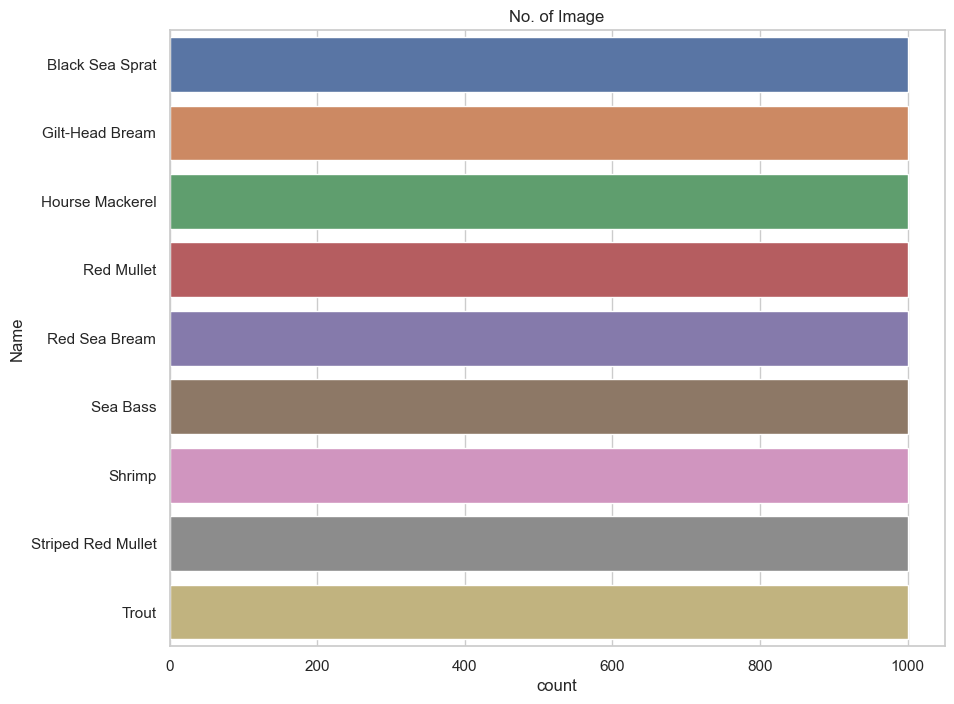

In [4]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,8))
ax = sns.countplot(y=df.Name)
ax.set_title('No. of Image');

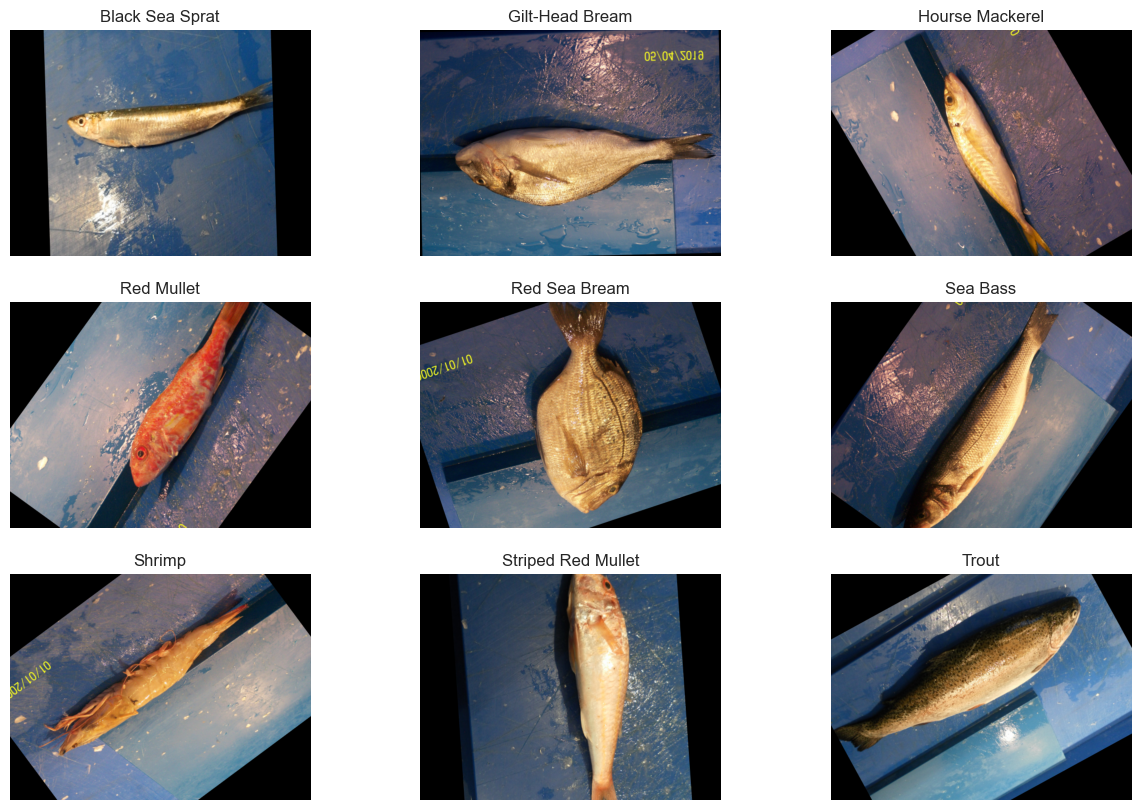

In [5]:
import random
fig, axs = plt.subplots(3,3,figsize=(15,10))
for i,x in enumerate(df.Name.value_counts().index):
    img = plt.imread(random.choice(df.loc[df.Name==df.Name.value_counts().index[i]].Path.to_list()))
    axs[int((i-i%3)/3),i%3].imshow(img)
    axs[int((i-i%3)/3),i%3].axis('off')
    axs[int((i-i%3)/3),i%3].set_title(x)

In [6]:
# Building Image Pipeline Referenced:
# https://www.kaggle.com/namtrn021200/fish-classification-tensorflow-input-pipeline

dataset = tf.data.Dataset.from_tensor_slices((df.Path,df.Label))
def get_train_val_test_split(ds,shuffle=True,shuffle_size=5000):
    ds_size=len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    train_size=int(ds_size*.8)
    val_size=int(ds_size*.1)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = get_train_val_test_split(dataset)

In [7]:
def load_images(filename,label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.convert_image_dtype(image,tf.float32)
    image = tf.image.resize(image,(224,224))
    return image,label
def augment(image,label):
    image = tf.image.random_brightness(image,max_delta=.2)
    image = tf.image.random_flip_left_right(image)
    iamge = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image)
    image = tf.image.stateless_random_jpeg_quality(image,min_jpeg_quality=90,
                                                  max_jpeg_quality=100,
                                                  seed=(np.random.randint(100),
                                                       np.random.randint(100)))
    return image,label

In [8]:
BATCH_SIZE=32
train_ds = (train_ds
    .shuffle(len(train_ds)*100,seed=42)
    .map(load_images)
    .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE))
test_ds =(test_ds
         .shuffle(len(test_ds)*100)
         .map(load_images)
         .cache()
         .batch(BATCH_SIZE)
         .prefetch(tf.data.AUTOTUNE))
val_ds =(val_ds
         .shuffle(len(test_ds)*100)
         .map(load_images)
         .cache()
         .batch(BATCH_SIZE)
         .prefetch(tf.data.AUTOTUNE))
batch = next(iter(train_ds))

In [9]:
import tensorflow_hub as hub

resnet_url = 'https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5'
feature_extractor_layer = hub.KerasLayer(resnet_url,
                                        trainable=False,
                                        name='feature_extraction_layer',
                                        input_shape=(224,224,3))
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                              patience=3,
                                                              verbose=1,
                                                              factor=.5,
                                                              min_lr=.00001)
model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dense(9,activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
history = model.fit(train_ds,
                 epochs=5,
                 validation_data=val_ds,
                 callbacks=[learning_rate_reduction])

Epoch 1/5
225/225 [==============================] - 482s 2s/step - loss: 0.2201 - accuracy: 0.9564 - val_loss: 0.0972 - val_accuracy: 0.9744 - lr: 0.0010
Epoch 2/5
225/225 [==============================] - 362s 2s/step - loss: 0.0238 - accuracy: 0.9996 - val_loss: 0.0648 - val_accuracy: 0.9811 - lr: 0.0010
Epoch 3/5
225/225 [==============================] - 285s 1s/step - loss: 0.0119 - accuracy: 0.9999 - val_loss: 0.0536 - val_accuracy: 0.9844 - lr: 0.0010
Epoch 4/5
225/225 [==============================] - 278s 1s/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.0481 - val_accuracy: 0.9856 - lr: 0.0010
Epoch 5/5
225/225 [==============================] - 1960s 9s/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.0448 - val_accuracy: 0.9856 - lr: 0.0010


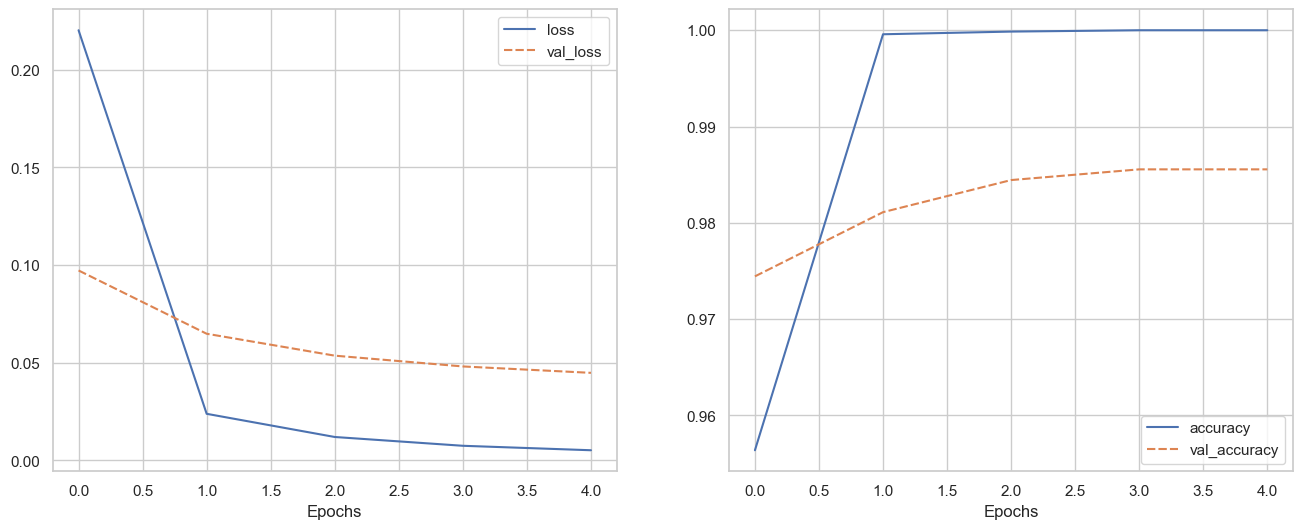

In [10]:
import seaborn as sns
def plot_history(history):
    fig,ax = plt.subplots(1,2,figsize=(16,6))
    history_data = pd.DataFrame(history.history)
    sns.lineplot(data=history_data[['loss','val_loss']],ax=ax[0])
    sns.lineplot(data=history_data[['accuracy','val_accuracy']],ax=ax[1])
    ax[0].set_xlabel('Epochs')
    ax[1].set_xlabel('Epochs');
plot_history(history)

In [14]:
from sklearn.metrics import classification_report

# Assuming you have the necessary imports and definitions for test_ds, model, and classes

# Extract labels from test dataset
test_data = [(example.numpy(), label.numpy()) for example, label in test_ds]
y_test = np.concatenate([label for _, label in test_data])

# Convert numeric labels to class names
y_test_class = [classes[x] for x in y_test]

# Predict using the model
y_pred = tf.argmax(model.predict(test_ds), axis=1)

# Convert numeric predicted labels to class names
y_pred_class = [classes[x] for x in y_pred.numpy()]  # Convert y_pred to NumPy array

# Print the classification report
print(classification_report(y_test_class, y_pred_class))


29/29 [==============================] - 31s 1s/step
                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00        91
   Gilt-Head Bream       1.00      0.99      0.99        90
   Hourse Mackerel       1.00      1.00      1.00        88
        Red Mullet       1.00      1.00      1.00        79
     Red Sea Bream       1.00      1.00      1.00        70
          Sea Bass       0.92      1.00      0.96        90
            Shrimp       1.00      1.00      1.00       104
Striped Red Mullet       1.00      1.00      1.00       132
             Trout       1.00      0.96      0.98       156

          accuracy                           0.99       900
         macro avg       0.99      0.99      0.99       900
      weighted avg       0.99      0.99      0.99       900

